## Importing libraries

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
import zipfile
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Reading datasets

In [2]:
top_20_overlap_service = pd.read_csv("../datasets/filtered_final_results.csv").head(20)
top_20_overlap_service['ServiceNo'] = top_20_overlap_service['ServiceNo'].astype(str)
print(top_20_overlap_service.info())

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/filtered_final_results.csv'

In [83]:
top_50_overlap_service = pd.read_csv('../datasets/filtered_final_results.csv').head(50)
top_50_overlap_service['ServiceNo'] = top_50_overlap_service['ServiceNo'].astype(str)

## Feature 1: Passenger Volume

In [84]:
pv_trend = pd.read_csv("../datasets/pv_eda/routes_pv_trend.csv")
print(pv_trend.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ServiceNo     400 non-null    object 
 1   2024-07       400 non-null    float64
 2   2024-08       400 non-null    float64
 3   2024-09       400 non-null    float64
 4   Trend         400 non-null    object 
 5   Trend_Binary  400 non-null    int64  
 6   Change        400 non-null    float64
 7   Average       400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB
None


In [85]:
top_20_pv_trend = pd.merge(top_20_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_20_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               1.792254   
1         219        48         105               1.513026   
2          12       107          79               1.419038   
3         196        36          61               1.380328   
4          38       122          39               1.323077   

                               TrainLineParallelData     2024-07     2024-08  \
0  {'BP': [{'ParallelStopCodes': ['44461', '44451...  40651926.0  40107168.0   
1  {'CC': [{'ParallelStopCodes': ['41021', '41119...   9789624.0   9783592.0   
2  {'DT': [{'ParallelStopCodes': ['60039', '60029...  11919460.0  11668796.0   
3  {'CC': [{'ParallelStopCodes': ['02149', '02171...   2731454.0   2755434.0   
4  {'EW': [{'ParallelStopCodes': ['06011', '06051...   2524376.0   2495384.0   

      2024-09       Trend  Trend_Binary     Change       Average  
0  37781528.0  Decreasing             0 -2870398.0  3.951354e+07  
1   9240800.

In [86]:
top_50_pv_trend = pd.merge(top_50_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_50_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               1.792254   
1         219        48         105               1.513026   
2          12       107          79               1.419038   
3         196        36          61               1.380328   
4          38       122          39               1.323077   

                               TrainLineParallelData     2024-07     2024-08  \
0  {'BP': [{'ParallelStopCodes': ['44461', '44451...  40651926.0  40107168.0   
1  {'CC': [{'ParallelStopCodes': ['41021', '41119...   9789624.0   9783592.0   
2  {'DT': [{'ParallelStopCodes': ['60039', '60029...  11919460.0  11668796.0   
3  {'CC': [{'ParallelStopCodes': ['02149', '02171...   2731454.0   2755434.0   
4  {'EW': [{'ParallelStopCodes': ['06011', '06051...   2524376.0   2495384.0   

      2024-09       Trend  Trend_Binary     Change       Average  
0  37781528.0  Decreasing             0 -2870398.0  3.951354e+07  
1   9240800.

In [87]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_20_pv_trend['Change_Normalized'] = top_20_pv_trend['Change'] / top_20_pv_trend['TotalStops']
top_20_pv_trend['Average_Normalized'] = top_20_pv_trend['Average'] / top_20_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_20_pv_trend['Change_Normalized'].mean()
change_std = top_20_pv_trend['Change_Normalized'].std()
top_20_pv_trend['Change_Standardized'] = (top_20_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
    -np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_20_pv_trend['Average_Standardized'] = scaler.fit_transform(top_20_pv_trend[['Average_Normalized']])

top_20_pv_trend = top_20_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 'TrainLineParallelData', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_20_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  \
0         67         163               1.792254   
1         48         105               1.513026   
2        107          79               1.419038   
3         36          61               1.380328   
4        122          39               1.323077   
5        170         130               1.241430   
6          2         131               1.195465   
7         63         102               1.188235   
8         65         128               1.184811   
9        100         111               1.180604   
10        24         100               1.174000   
11        80         118               1.173851   
12       851         108               1.150687   
13       111          56               1.146429   
14       134          36               1.127778   
15       158          69               1.124638   
16        13         129               1.099351   
17       133          86               1.083658   
18       147         146       

In [88]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_50_pv_trend['Change_Normalized'] = top_50_pv_trend['Change'] / top_50_pv_trend['TotalStops']
top_50_pv_trend['Average_Normalized'] = top_50_pv_trend['Average'] / top_50_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_50_pv_trend['Change_Normalized'].mean()
change_std = top_50_pv_trend['Change_Normalized'].std()
top_50_pv_trend['Change_Standardized'] = (top_50_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
    -np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_50_pv_trend['Average_Standardized'] = scaler.fit_transform(top_50_pv_trend[['Average_Normalized']])

top_50_pv_trend = top_50_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 'TrainLineParallelData', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_50_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  \
0         67         163               1.792254   
1         48         105               1.513026   
2        107          79               1.419038   
3         36          61               1.380328   
4        122          39               1.323077   
5        170         130               1.241430   
6          2         131               1.195465   
7         63         102               1.188235   
8         65         128               1.184811   
9        100         111               1.180604   
10        24         100               1.174000   
11        80         118               1.173851   
12       851         108               1.150687   
13       111          56               1.146429   
14       134          36               1.127778   
15       158          69               1.124638   
16        13         129               1.099351   
17       133          86               1.083658   
18       147         146       

## Count of alternative bus routes

In [89]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)

In [90]:
# Filter for Trunk Services
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
trunk_buses_df = trunk_buses_df['ServiceNo']
trunk_bus_routes_df = pd.merge(trunk_buses_df, bus_routes_df, on='ServiceNo', how='inner')

# Select relevant columns
trunk_bus_routes_df = trunk_bus_routes_df[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode']]

# Sort the trunk bus routes by Direction and StopSequence
trunk_bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'], inplace=True)

# Group by ServiceNo and create an ordered list of BusStopCodes for each service
ordered_stops = trunk_bus_routes_df.groupby('ServiceNo').agg(
    OrderedBusStops=('BusStopCode', lambda x: list(x))
).reset_index()

# Display the result
print(ordered_stops.head())

  ServiceNo                                    OrderedBusStops
0        10  [75009, 75009, 76059, 76059, 76069, 76069, 962...
1       100  [66009, 66009, 62129, 62129, 62119, 62119, 610...
2      100A  [66009, 62129, 62119, 61049, 61039, 70069, 700...
3       101  [66009, 62131, 62141, 63011, 63021, 63031, 630...
4       102  [64009, 64041, 64051, 64061, 64401, 67739, 677...


## Feature 3 : Average Distance of bus stops to train stations 

In [91]:
avg_dist_df = pd.read_pickle("../datasets/overlap_results_with_road_distance3.pkl")

In [92]:
avg_dist_df.head()

,ServiceNo,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,10,146,0.855912,0.001797,"{'75009': [[0.23621599952756797, 'EW2', 'East-...",TRUNK
1,100,109,0.838644,0.001828,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK
2,100A,13,0.870323,0.001771,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK
3,101,45,0.822894,0.001857,"{'62131': [[0.184851999630296, 'NE12', 'North ...",TRUNK
4,102,59,0.857730,0.001794,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK


In [93]:
top_20_features = pd.merge(top_20_pv_trend,avg_dist_df, on = 'ServiceNo')

In [94]:
top_50_features = pd.merge(top_50_pv_trend,avg_dist_df, on = 'ServiceNo')

In [95]:
top_50_features

,ServiceNo,TotalStops,WeightedParallelScore,TrainLineParallelData,Trend_Binary,Change_Standardized,Average_Standardized,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,67,163,1.792254,"{'BP': [{'ParallelStopCodes': ['44461', '44451...",0,-1.516563,0.583099,161,0.737742,0.002022,"{'44009': [[0.6490839987018319, 'NS4', 'North-...",TRUNK
1,48,105,1.513026,"{'CC': [{'ParallelStopCodes': ['41021', '41119...",0,-0.655060,0.152888,103,0.773233,0.001952,"{'85099': [[0.26772999946453996, 'EW4', 'East-...",TRUNK
2,107,79,1.419038,"{'DT': [{'ParallelStopCodes': ['60039', '60029...",0,-0.112387,0.310069,77,0.745774,0.002006,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK
3,36,61,1.380328,"{'CC': [{'ParallelStopCodes': ['02149', '02171...",1,1.290152,0.018647,60,0.668416,0.002167,"{'95129': [[0.0, 'CG2', 'Changi Airport Branch...",TRUNK
4,122,39,1.323077,"{'EW': [{'ParallelStopCodes': ['06011', '06051...",0,-0.844192,0.072011,38,0.805609,0.001890,"{'10017': [[0.74851999850296, 'EW16', 'East-We...",TRUNK
5,170,130,1.241430,"{'DT': [{'ParallelStopCodes': ['07531', '40011...",0,-0.523782,0.353073,126,0.772111,0.001954,"{'01109': [[0.6014639987970719, 'DT22', 'Downt...",TRUNK
6,2,131,1.195465,"{'DT': [{'ParallelStopCodes': ['96059', '04239...",0,-0.066302,0.234075,129,0.848269,0.001811,"{'96059': [[0.337453999325092, 'DT34', 'Downto...",TRUNK
7,63,102,1.188235,"{'CC': [{'ParallelStopCodes': ['70181'], 'Para...",0,-0.835736,0.075063,101,0.730902,0.002036,"{'82009': [[0.251325999497348, 'EW7', 'East-We...",TRUNK
8,65,128,1.184811,"{'CC': [{'ParallelStopCodes': ['08031', '14019...",0,-0.816176,0.459643,126,0.795562,0.001909,"{'75009': [[0.23621599952756797, 'EW2', 'East-...",TRUNK
9,100,111,1.180604,"{'CC': [{'ParallelStopCodes': ['01429', '01419...",0,-0.746866,0.285032,109,0.838644,0.001828,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK


In [96]:
top_20_features

,ServiceNo,TotalStops,WeightedParallelScore,TrainLineParallelData,Trend_Binary,Change_Standardized,Average_Standardized,TotalBusStops,AvgNormalizedDistance,SoftmaxAvgDistance,NormalizedDistances,Category
0,67,163,1.792254,"{'BP': [{'ParallelStopCodes': ['44461', '44451...",0,-2.160795,1.000000,161,0.737742,0.002022,"{'44009': [[0.6490839987018319, 'NS4', 'North-...",TRUNK
1,48,105,1.513026,"{'CC': [{'ParallelStopCodes': ['41021', '41119...",0,-0.591609,0.262200,103,0.773233,0.001952,"{'85099': [[0.26772999946453996, 'EW4', 'East-...",TRUNK
2,107,79,1.419038,"{'DT': [{'ParallelStopCodes': ['60039', '60029...",0,-0.381085,0.531761,77,0.745774,0.002006,"{'64009': [[0.350813999298372, 'NE14', 'North ...",TRUNK
3,36,61,1.380328,"{'CC': [{'ParallelStopCodes': ['02149', '02171...",1,1.396551,0.031979,60,0.668416,0.002167,"{'95129': [[0.0, 'CG2', 'Changi Airport Branch...",TRUNK
4,122,39,1.323077,"{'EW': [{'ParallelStopCodes': ['06011', '06051...",0,-0.831323,0.123498,38,0.805609,0.001890,"{'10017': [[0.74851999850296, 'EW16', 'East-We...",TRUNK
5,170,130,1.241430,"{'DT': [{'ParallelStopCodes': ['07531', '40011...",0,-0.425222,0.605512,126,0.772111,0.001954,"{'01109': [[0.6014639987970719, 'DT22', 'Downt...",TRUNK
6,2,131,1.195465,"{'DT': [{'ParallelStopCodes': ['96059', '04239...",0,-0.154607,0.401434,129,0.848269,0.001811,"{'96059': [[0.337453999325092, 'DT34', 'Downto...",TRUNK
7,63,102,1.188235,"{'CC': [{'ParallelStopCodes': ['70181'], 'Para...",0,-0.820605,0.128731,101,0.730902,0.002036,"{'82009': [[0.251325999497348, 'EW7', 'East-We...",TRUNK
8,65,128,1.184811,"{'CC': [{'ParallelStopCodes': ['08031', '14019...",0,-1.273096,0.788277,126,0.795562,0.001909,"{'75009': [[0.23621599952756797, 'EW2', 'East-...",TRUNK
9,100,111,1.180604,"{'CC': [{'ParallelStopCodes': ['01429', '01419...",0,-0.707967,0.488822,109,0.838644,0.001828,"{'62129': [[0.691723998616552, 'NE12', 'North ...",TRUNK


In [97]:
top_20_features = top_20_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_20_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [98]:
top_50_features = top_50_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_50_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [99]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT
0,67,1.792254,-1.516563,0.737742
1,48,1.513026,-0.655060,0.773233
2,107,1.419038,-0.112387,0.745774
3,36,1.380328,1.290152,0.668416
4,122,1.323077,-0.844192,0.805609
5,170,1.241430,-0.523782,0.772111
6,2,1.195465,-0.066302,0.848269
7,63,1.188235,-0.835736,0.730902
8,65,1.184811,-0.816176,0.795562
9,100,1.180604,-0.746866,0.838644


In [100]:
# # Apply StandardScaler to standardize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled_20 = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

In [117]:
features_scaled_20

array([[1.        , 0.        , 0.30689715],
       [0.60938085, 0.44111151, 0.4640084 ],
       [0.47789923, 0.50029171, 0.3424511 ],
       [0.42374605, 1.        , 0.        ],
       [0.34365632, 0.37372589, 0.60733168],
       [0.22943835, 0.48788435, 0.45904194],
       [0.16513715, 0.56395655, 0.79618292],
       [0.1550231 , 0.37673889, 0.27661397],
       [0.15023241, 0.24953988, 0.56285638],
       [0.1443479 , 0.40840218, 0.7535729 ],
       [0.135109  , 0.55955251, 0.68711638],
       [0.13489997, 0.53353093, 0.54200159],
       [0.10249562, 0.33998095, 0.46840426],
       [0.09653866, 0.16566299, 0.15198784],
       [0.07044762, 0.39361345, 0.4006501 ],
       [0.06605486, 0.35350842, 0.09297187],
       [0.03068066, 0.20970856, 0.9601579 ],
       [0.0087274 , 0.4491157 , 0.36668792],
       [0.0021915 , 0.33682282, 0.54024654],
       [0.        , 0.52701637, 1.        ]])

DBSCAN Cluster Assignments:
[-1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0  0  0
 -1]


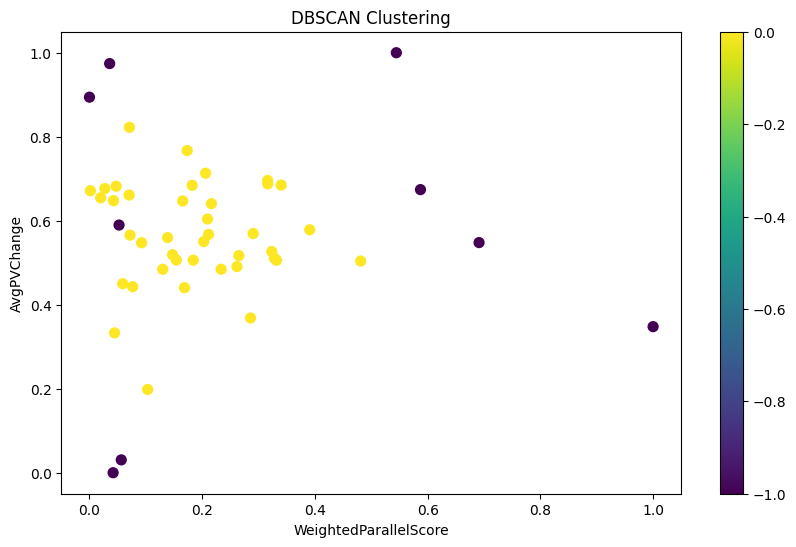

In [122]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=3)  # You can adjust `eps` and `min_samples` based on trial and error
dbscan_labels = dbscan.fit_predict(features_scaled)

# Check the cluster assignments
print("DBSCAN Cluster Assignments:")
print(dbscan_labels)

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title('DBSCAN Clustering')
plt.xlabel('WeightedParallelScore')
plt.ylabel('AvgPVChange')
plt.show()


In [101]:
# # Apply StandardScaler to standardize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(top_50_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

### KNN :50 bus services

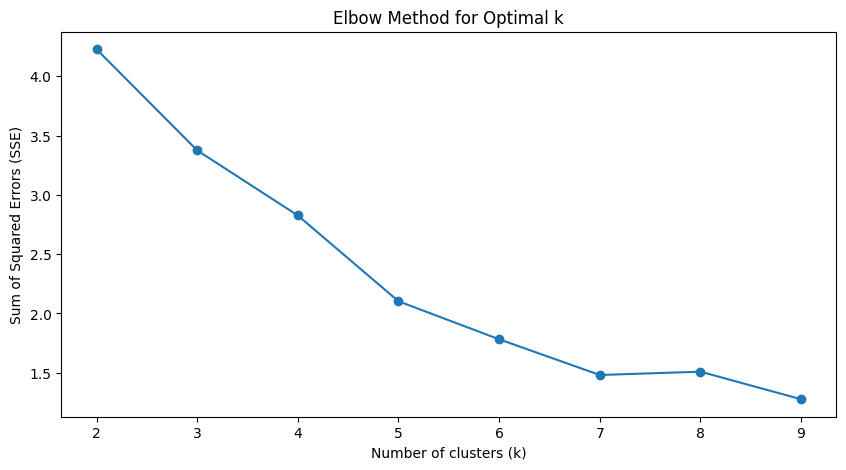

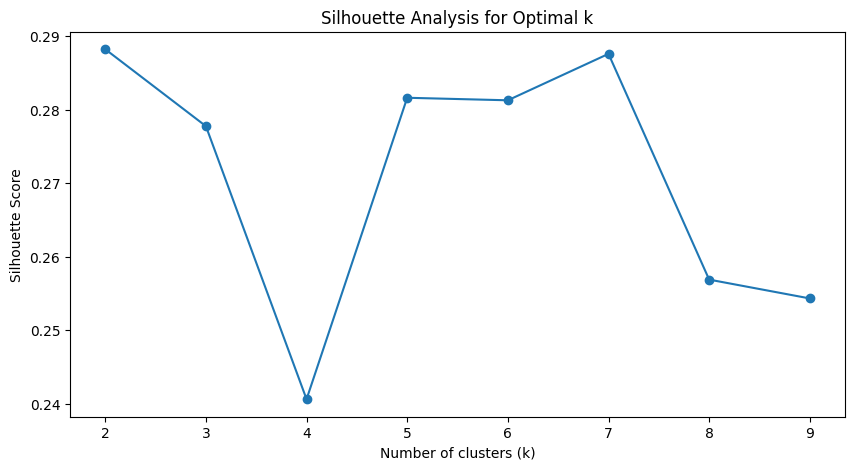

Silhouette score for k=2: 0.288
Silhouette score for k=3: 0.278
Silhouette score for k=4: 0.241
Silhouette score for k=5: 0.282
Silhouette score for k=6: 0.281
Silhouette score for k=7: 0.288
Silhouette score for k=8: 0.257
Silhouette score for k=9: 0.254


In [102]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.16618149 0.60683163 0.51125458]
 [0.16184815 0.61142965 0.81283695]
 [0.68990429 0.51844577 0.453251  ]
 [0.24006763 0.58792008 0.16061245]
 [0.06721508 0.07629201 0.81369137]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.347754          0.337552        2
1               0.691206     0.547957          0.485008        2
2               0.587267     0.674067          0.370921        2
3               0.544457     1.000000          0.049515        3
4               0.481144     0.504005          0.619523        2


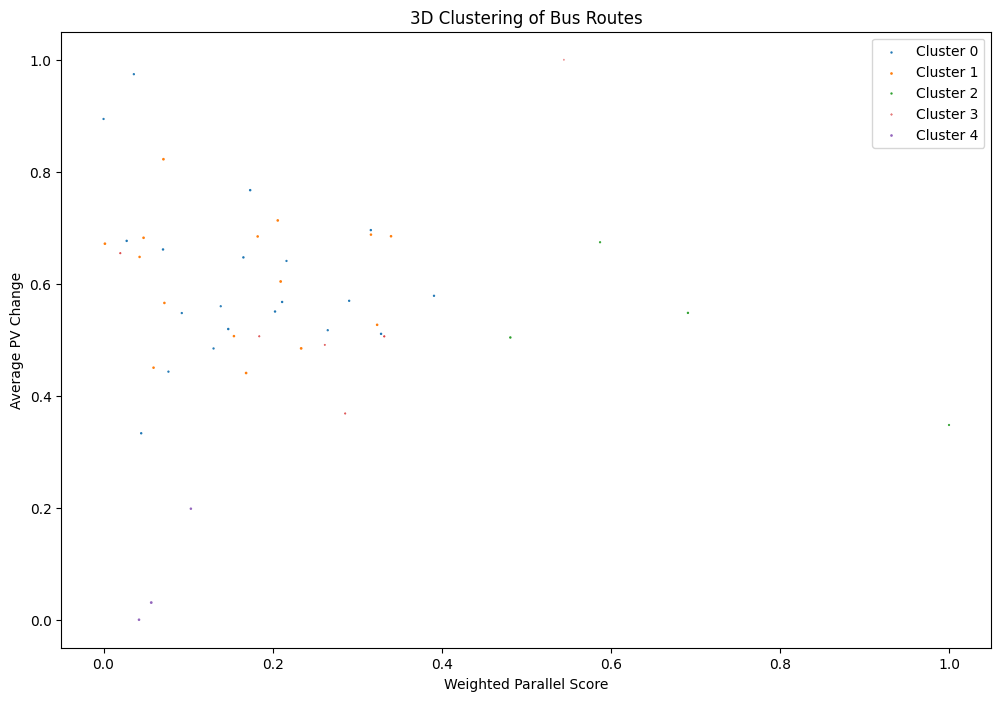

In [103]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming features array is already normalized and stored in a variable called `features`
k = 5  # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_50_features_df = pd.DataFrame(features_scaled, columns=columns)
top_50_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_50_features_df.head())


plt.figure(figsize=(12, 8))
for i in range(k):
    cluster_data = top_50_features_df[top_50_features_df['Cluster'] == i]
    plt.scatter(cluster_data['WeightedParallelScore'], cluster_data['AvgPVChange'], cluster_data['AvgDistanceToMRT'], label=f'Cluster {i}')

plt.xlabel('Weighted Parallel Score')
plt.ylabel('Average PV Change')
plt.title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




In [104]:
# Ensure that you are assigning the cluster column using .loc
top_50_features.loc[:, 'Clusters_KNN'] = top_50_features_df['Cluster'].values

/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_66685/3605315376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_50_features.loc[:, 'Clusters_KNN'] = top_50_features_df['Cluster'].values


In [105]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN
0,67,1.792254,-1.516563,0.737742,2
1,48,1.513026,-0.655060,0.773233,2
2,107,1.419038,-0.112387,0.745774,2
3,36,1.380328,1.290152,0.668416,3
4,122,1.323077,-0.844192,0.805609,2
5,170,1.241430,-0.523782,0.772111,0
6,2,1.195465,-0.066302,0.848269,1
7,63,1.188235,-0.835736,0.730902,3
8,65,1.184811,-0.816176,0.795562,0
9,100,1.180604,-0.746866,0.838644,1


### knn : 20 BUS Services

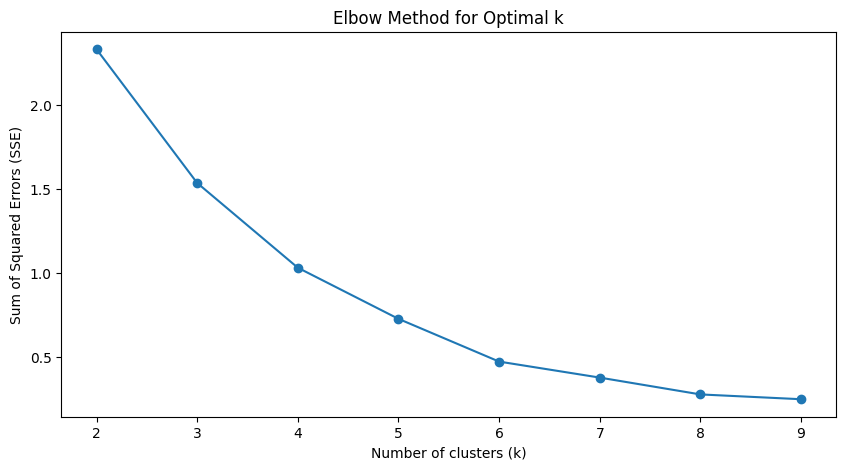

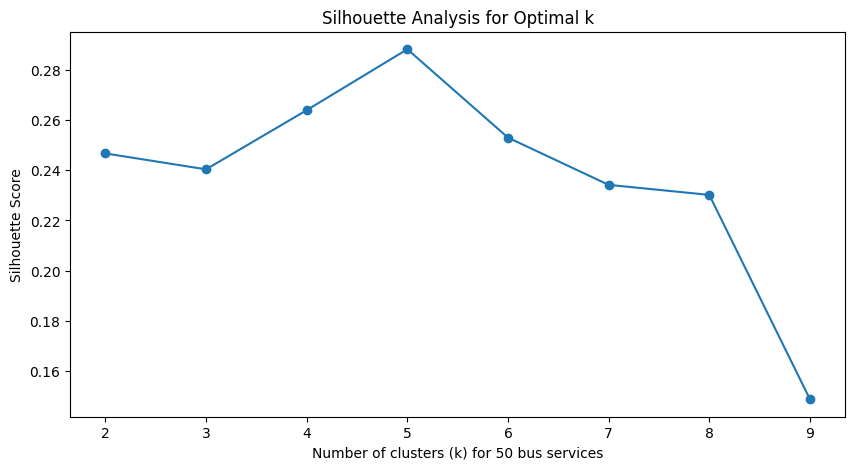

Silhouette score for k=2: 0.247
Silhouette score for k=3: 0.240
Silhouette score for k=4: 0.264
Silhouette score for k=5: 0.288
Silhouette score for k=6: 0.253
Silhouette score for k=7: 0.234
Silhouette score for k=8: 0.230
Silhouette score for k=9: 0.149


In [106]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_20)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled_20)
    silhouette_avg = silhouette_score(features_scaled_20, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k) for 50 bus services')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.10410366 0.36664354 0.31662256]
 [0.12291721 0.41802841 0.71660737]
 [1.         0.         0.30689715]
 [0.42374605 1.         0.        ]
 [0.54364004 0.47070161 0.40322975]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.000000          0.306897        2
1               0.609381     0.441112          0.464008        4
2               0.477899     0.500292          0.342451        4
3               0.423746     1.000000          0.000000        3
4               0.343656     0.373726          0.607332        1


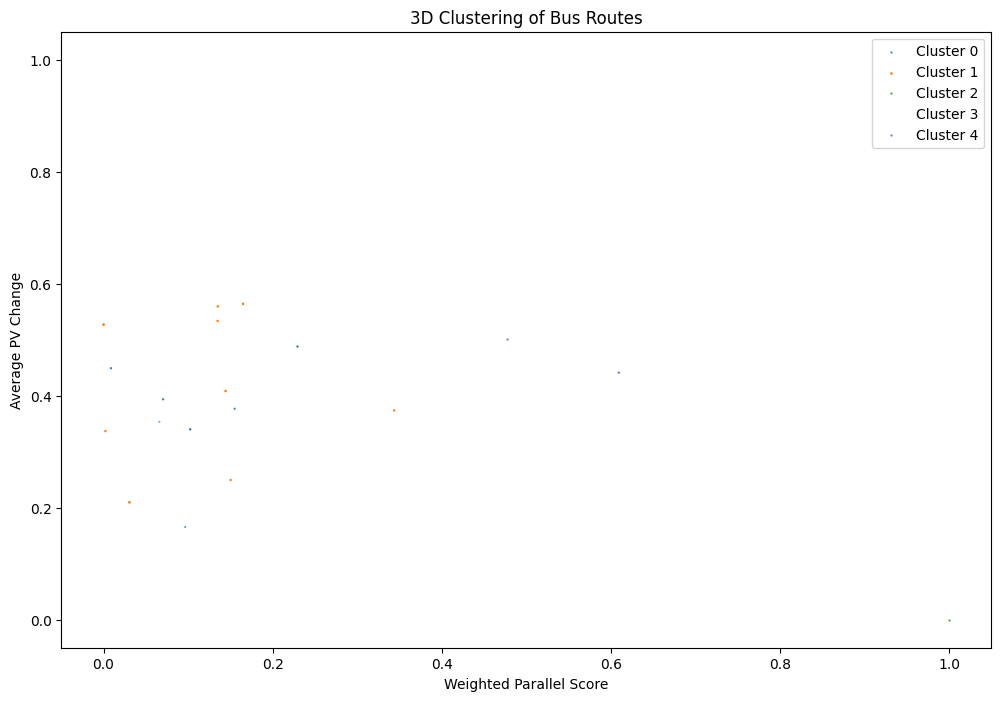

In [107]:
k = 5  # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled_20)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_20_features_df = pd.DataFrame(features_scaled_20, columns=columns)
top_20_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_20_features_df.head())


plt.figure(figsize=(12, 8))
for i in range(k):
    cluster_data = top_20_features_df[top_20_features_df['Cluster'] == i]
    plt.scatter(cluster_data['WeightedParallelScore'], cluster_data['AvgPVChange'], cluster_data['AvgDistanceToMRT'], label=f'Cluster {i}')

plt.xlabel('Weighted Parallel Score')
plt.ylabel('Average PV Change')
plt.title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




In [108]:
# Ensure that you are assigning the cluster column using .loc
top_20_features.loc[:, 'Clusters_KNN'] = top_20_features_df['Cluster'].values

/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_66685/3359829673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_features.loc[:, 'Clusters_KNN'] = top_20_features_df['Cluster'].values


In [109]:
top_20_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN
0,67,1.792254,-2.160795,0.737742,2
1,48,1.513026,-0.591609,0.773233,4
2,107,1.419038,-0.381085,0.745774,4
3,36,1.380328,1.396551,0.668416,3
4,122,1.323077,-0.831323,0.805609,1
5,170,1.241430,-0.425222,0.772111,0
6,2,1.195465,-0.154607,0.848269,1
7,63,1.188235,-0.820605,0.730902,0
8,65,1.184811,-1.273096,0.795562,1
9,100,1.180604,-0.707967,0.838644,1


### Hierarchical Clustering : 50 Bus Services

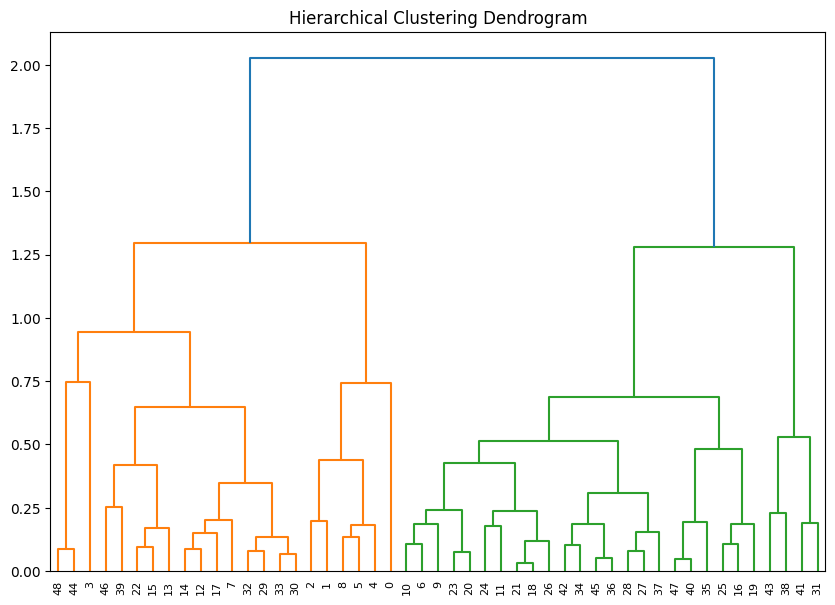

ValueError: Length of values (49) does not match length of index (20)

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in `top_20_features` DataFrame
# and contains 'WeightedParallelScore', 'AvgPVChange', and 'AvgDistanceToMRT' columns

# # Step 1: Normalize the data using MinMaxScaler (or StandardScaler if preferred)
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

# Step 2: Perform hierarchical clustering
linked = linkage(features_scaled, method='ward')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Step 4: Cut the dendrogram to form clusters
num_clusters = 5
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_50_features['Cluster_HC'] = cluster_labels

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_50_features)


In [112]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,1.792254,-1.516563,0.737742,2,3
1,48,1.513026,-0.655060,0.773233,2,3
2,107,1.419038,-0.112387,0.745774,2,3
3,36,1.380328,1.290152,0.668416,3,5
4,122,1.323077,-0.844192,0.805609,2,3
5,170,1.241430,-0.523782,0.772111,0,3
6,2,1.195465,-0.066302,0.848269,1,2
7,63,1.188235,-0.835736,0.730902,3,4
8,65,1.184811,-0.816176,0.795562,0,3
9,100,1.180604,-0.746866,0.838644,1,2


### Hierarchical Clustering : 20 Bus Services

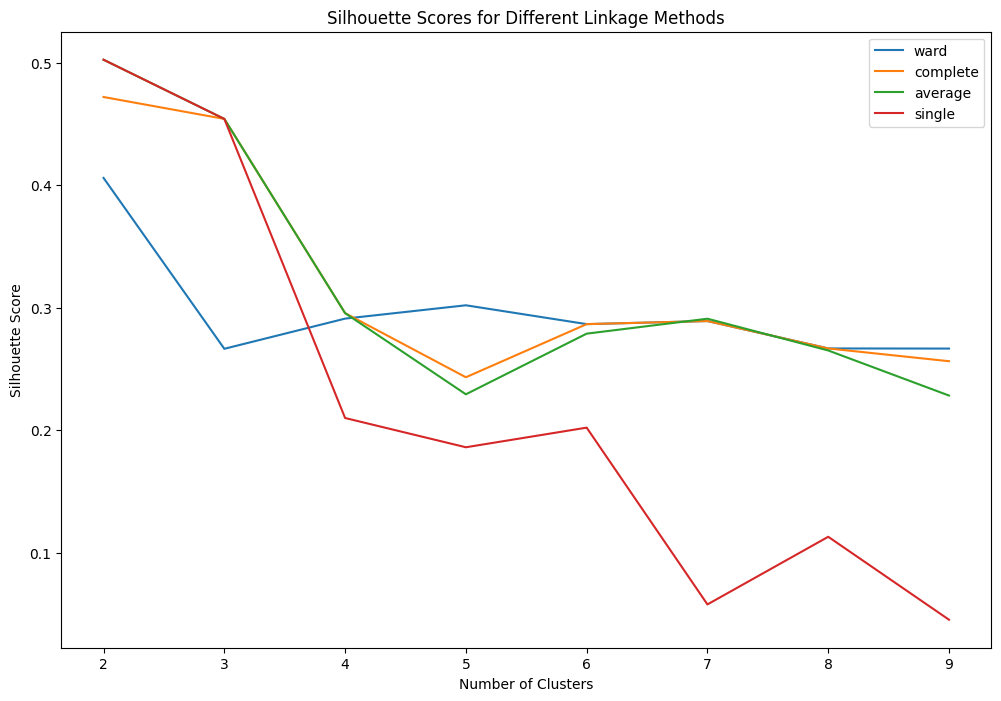

In [129]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

for method in linkage_methods:
    linked = linkage(features_scaled_20, method=method)
    silhouette_scores[method] = []

    # Test silhouette score for different number of clusters
    for k in range(2, 10):  # Test from 2 to 10 clusters
        cluster_labels = fcluster(linked, k, criterion='maxclust')
        score = silhouette_score(features_scaled_20, cluster_labels)
        silhouette_scores[method].append(score)

# Plot silhouette scores for each method
plt.figure(figsize=(12, 8))
for method in silhouette_scores:
    plt.plot(range(2, 10), silhouette_scores[method], label=method)

plt.title("Silhouette Scores for Different Linkage Methods")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


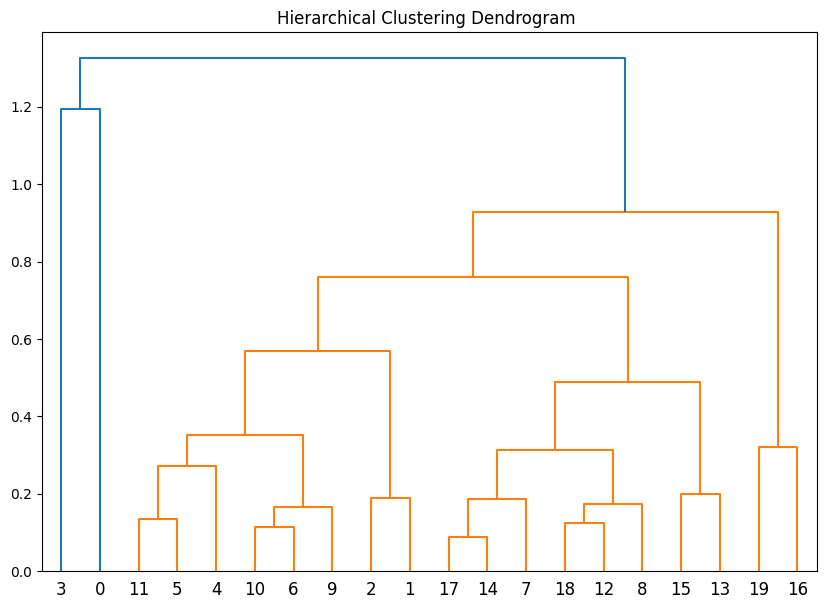

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Clusters_KNN  \
0         67               1.792254 -2.160795          0.737742             2   
1         48               1.513026 -0.591609          0.773233             4   
2        107               1.419038 -0.381085          0.745774             4   
3         36               1.380328  1.396551          0.668416             3   
4        122               1.323077 -0.831323          0.805609             1   
5        170               1.241430 -0.425222          0.772111             0   
6          2               1.195465 -0.154607          0.848269             1   
7         63               1.188235 -0.820605          0.730902             0   
8         65               1.184811 -1.273096          0.795562             1   
9        100               1.180604 -0.707967          0.838644             1   
10        24               1.174000 -0.170273          0.823632             1   
11     

/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_66685/908997965.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_features['Cluster_HC'] = cluster_labels-1


In [133]:
#Perform hierarchical clustering
linked = linkage(features_scaled_20, method='complete')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram ')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Step 4: Cut the dendrogram to form clusters
num_clusters = 3
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_20_features['Cluster_HC'] = cluster_labels-1

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_20_features)